In [1]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *
from OA_utils.eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from OA_lstm import LSTMModel
from OA_cnnlstm import CNNLSTMModel
from OA_lstmattn import LSTMAttentionModel
from OA_transformer import TransformerModel

In [2]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [3]:
# data_dir = "C:\\Users\\bakel\\Desktop\\GRFMuscleModel\\Old_Young_Walking_Data\\"
data_dir = "/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/"

train_data = np.load(data_dir + 'mixed_train_data.npz')
val_data = np.load(data_dir + 'mixed_val_data.npz')
test_data = np.load(data_dir + 'mixed_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [4]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1153, 100, 3)
y_train shape: (1153, 100, 9)
X_val shape: (142, 100, 3)
y_val shape: (142, 100, 9)
X_test shape: (116, 100, 3)
y_test shape: (116, 100, 9)


In [5]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [6]:
muscle_stats = load_muscle_stats('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_muscle_forces_stats_100.txt')

In [7]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=3, 
                       output_size=9, 
                       dropout= 0.09055521529077426)

lstm_model.load_state_dict(torch.load('../models/Mixed_lstm.pth', map_location=device, weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.09055521529077426)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [8]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 11006.287109375


In [ ]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.1415
tibant: 0.1117
edl: 0.1079
ehl: 0.0782
fdl: 0.1383
fhl: 0.1547
perbrev: 0.1231
perlong: 0.1029
achilles: 0.0705


In [10]:
lstm_mae, lstm_norm_mae, lstm_overall_norm_mae = calc_mae_muscle_normalized(y_test, lstm_pred)

tibpost: MAE:78.5747; Normalized MAE:0.1974
tibant: MAE:41.8176; Normalized MAE:0.1000
edl: MAE:11.9822; Normalized MAE:0.1022
ehl: MAE:1.8614; Normalized MAE:0.0816
fdl: MAE:3.7527; Normalized MAE:0.1770
fhl: MAE:16.7194; Normalized MAE:0.2320
perbrev: MAE:9.6922; Normalized MAE:0.2406
perlong: MAE:29.6772; Normalized MAE:0.2058
achilles: MAE:206.8540; Normalized MAE:0.0926


In [11]:
lstm_mae = calc_mae_muscle(y_test, lstm_pred)

tibpost: 78.5747
tibant: 41.8176
edl: 11.9822
ehl: 1.8614
fdl: 3.7527
fhl: 16.7194
perbrev: 9.6922
perlong: 29.6772
achilles: 206.8540


In [12]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: 0.4437
tibant: 0.6940
edl: 0.3767
ehl: 0.5469
fdl: 0.5017
fhl: 0.3978
perbrev: 0.0367
perlong: 0.0722
achilles: 0.8552


In [13]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=2, 
                             output_size=9, 
                             dropout= 0.3221114178836374)

cnnlstm_model.load_state_dict(torch.load('../models/Mixed_cnn-lstm.pth', map_location=device, weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3221114178836374)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [14]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 21667.0078125


In [15]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.1436
tibant: 0.1135
edl: 0.1087
ehl: 0.0782
fdl: 0.1479
fhl: 0.1549
perbrev: 0.1177
perlong: 0.1030
achilles: 0.1041


In [17]:
cnnlstm_mae, cnnlstm_norm_mae, cnnlstm_overall_norm_mae = calc_mae_muscle_normalized(y_test, cnnlstm_pred)

tibpost: MAE:82.0820; Normalized MAE:0.2062
tibant: MAE:43.7002; Normalized MAE:0.1045
edl: MAE:11.9765; Normalized MAE:0.1021
ehl: MAE:1.7751; Normalized MAE:0.0778
fdl: MAE:3.9973; Normalized MAE:0.1886
fhl: MAE:17.4391; Normalized MAE:0.2420
perbrev: MAE:8.7703; Normalized MAE:0.2177
perlong: MAE:28.8540; Normalized MAE:0.2001
achilles: MAE:318.1668; Normalized MAE:0.1425


In [18]:
cnnlstm_mae = calc_mae_muscle(y_test, cnnlstm_pred)

tibpost: 82.0820
tibant: 43.7002
edl: 11.9765
ehl: 1.7751
fdl: 3.9973
fhl: 17.4391
perbrev: 8.7703
perlong: 28.8540
achilles: 318.1668


In [19]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: 0.4273
tibant: 0.6841
edl: 0.3667
ehl: 0.5474
fdl: 0.4306
fhl: 0.3970
perbrev: 0.1207
perlong: 0.0698
achilles: 0.6845


In [20]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=2, 
                                    num_heads=4, 
                                    output_size=9, 
                                    lstm_dropout= 0.2649797291817925, 
                                    attn_dropout= 0.2152143708632664)

lstmattn_model.load_state_dict(torch.load('../models/Mixed_lstm-attn.pth', map_location=device, weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True, dropout=0.2649797291817925)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [21]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 9228.3134765625


In [22]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.1447
tibant: 0.1182
edl: 0.1133
ehl: 0.0885
fdl: 0.1498
fhl: 0.1704
perbrev: 0.1230
perlong: 0.1135
achilles: 0.0624


In [23]:
lstmattn_mae, lstmattn_norm_mae, lstmattn_overall_norm_mae = calc_mae_muscle_normalized(y_test, lstmattn_pred)

tibpost: MAE:79.8383; Normalized MAE:0.2005
tibant: MAE:44.1294; Normalized MAE:0.1056
edl: MAE:12.6982; Normalized MAE:0.1083
ehl: MAE:2.7445; Normalized MAE:0.1203
fdl: MAE:4.2527; Normalized MAE:0.2006
fhl: MAE:19.8081; Normalized MAE:0.2749
perbrev: MAE:8.9693; Normalized MAE:0.2227
perlong: MAE:34.3491; Normalized MAE:0.2382
achilles: MAE:189.0870; Normalized MAE:0.0847


In [24]:
lstmattn_mae = calc_mae_muscle(y_test, lstmattn_pred)

tibpost: 79.8383
tibant: 44.1294
edl: 12.6982
ehl: 2.7445
fdl: 4.2527
fhl: 19.8081
perbrev: 8.9693
perlong: 34.3491
achilles: 189.0870


In [25]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: 0.4186
tibant: 0.6573
edl: 0.3121
ehl: 0.4201
fdl: 0.4156
fhl: 0.2702
perbrev: 0.0395
perlong: -0.1289
achilles: 0.8867


In [26]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=64, 
                                     nhead=4, 
                                     num_encoder_layers=4, 
                                     dim_feedforward=128, 
                                     dropout= 8.157533419504703e-05)

transformer_model.load_state_dict(torch.load('../models/Mixed_transformer.pth', map_location=device, weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=8.157533419504703e-05, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=8.157533419504703e-05, inplace=False)
        (dropout2): Dropout(p=8.157533419504703e-05, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

In [27]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 8892.185546875


In [28]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.1626
tibant: 0.1234
edl: 0.1133
ehl: 0.0808
fdl: 0.1633
fhl: 0.1770
perbrev: 0.1230
perlong: 0.1048
achilles: 0.0594


In [29]:
transformer_mae, transformer_norm_mae, transformer_overall_norm_mae = calc_mae_muscle_normalized(y_test, transformer_pred)

tibpost: MAE:83.7806; Normalized MAE:0.2104
tibant: MAE:48.2379; Normalized MAE:0.1154
edl: MAE:14.4200; Normalized MAE:0.1230
ehl: MAE:2.0693; Normalized MAE:0.0907
fdl: MAE:4.2383; Normalized MAE:0.1999
fhl: MAE:18.1353; Normalized MAE:0.2517
perbrev: MAE:9.8868; Normalized MAE:0.2455
perlong: MAE:30.9441; Normalized MAE:0.2146
achilles: MAE:155.1491; Normalized MAE:0.0695


In [30]:
transformer_mae = calc_mae_muscle(y_test, transformer_pred)

tibpost: 83.7806
tibant: 48.2379
edl: 14.4200
ehl: 2.0693
fdl: 4.2383
fhl: 18.1353
perbrev: 9.8868
perlong: 30.9441
achilles: 155.1491


In [31]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: 0.2653
tibant: 0.6261
edl: 0.3119
ehl: 0.5166
fdl: 0.3060
fhl: 0.2123
perbrev: 0.0390
perlong: 0.0363
achilles: 0.8974


In [32]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 104.91085394011182
CNN-LSTM RMSE Overall: 147.19717589080616
LSTM-Attention RMSE Overall: 96.06411182697461
Transformer RMSE Overall: 94.29838650338263


In [33]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.0255585270672925
CNN-LSTM RRMSE Overall: 0.03586037919757852
LSTM-Attention RRMSE Overall: 0.023403271540680847
Transformer RRMSE Overall: 0.022973103099747257


In [34]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.08922745483525557
CNN-LSTM RRMSE Weighted: 0.11091276963393736
LSTM-Attention RRMSE Weighted: 0.08646178625448579
Transformer RRMSE Weighted: 0.08663725884832729


In [35]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 0.7914055275182342
CNN-LSTM RMSPE: 0.9085415179078417
LSTM-Attention RMSPE: 0.9161176424408146
Transformer RMSPE: 0.9283369953547493


In [36]:
lstm_mae_overall = calc_mae_overall(y_test, lstm_pred)
print(f"LSTM MAE Overall: {lstm_mae_overall}")

cnnlstm_mae_overall = calc_mae_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Overall: {cnnlstm_mae_overall}")

lstmattn_mae_overall = calc_mae_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Overall: {lstmattn_mae_overall}")

transformer_mae_overall = calc_mae_overall(y_test, transformer_pred)
print(f"Transformer MAE Overall: {transformer_mae_overall}")

LSTM MAE Overall: 44.54794764495832
CNN-LSTM MAE Overall: 57.41793004677361
LSTM-Attention MAE Overall: 43.98628913903123
Transformer MAE Overall: 40.76238584657327


In [37]:
lstm_mae_weighted = calc_mae_weighted(y_test, lstm_pred)
print(f"LSTM MAE Weighted: {lstm_mae_weighted}")

cnnlstm_mae_weighted = calc_mae_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Weighted: {cnnlstm_mae_weighted}")

lstmattn_mae_weighted = calc_mae_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Weighted: {lstmattn_mae_weighted}")

transformer_mae_weighted = calc_mae_weighted(y_test, transformer_pred)
print(f"Transformer MAE Weighted: {transformer_mae_weighted}")

LSTM MAE Weighted: 0.06295305334630562
CNN-LSTM MAE Weighted: 0.08114030397263583
LSTM-Attention MAE Weighted: 0.06215934410143013
Transformer MAE Weighted: 0.057603476397468587


In [38]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9153933409706975
CNN-LSTM R2: 0.8334430891845716
LSTM-Attention R2: 0.9290608393999463
Transformer R2: 0.9316446950235252


In [39]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9153933409706975
CNN-LSTM R2: 0.8334430891845716
LSTM-Attention R2: 0.9290608393999463
Transformer R2: 0.9316446950235252


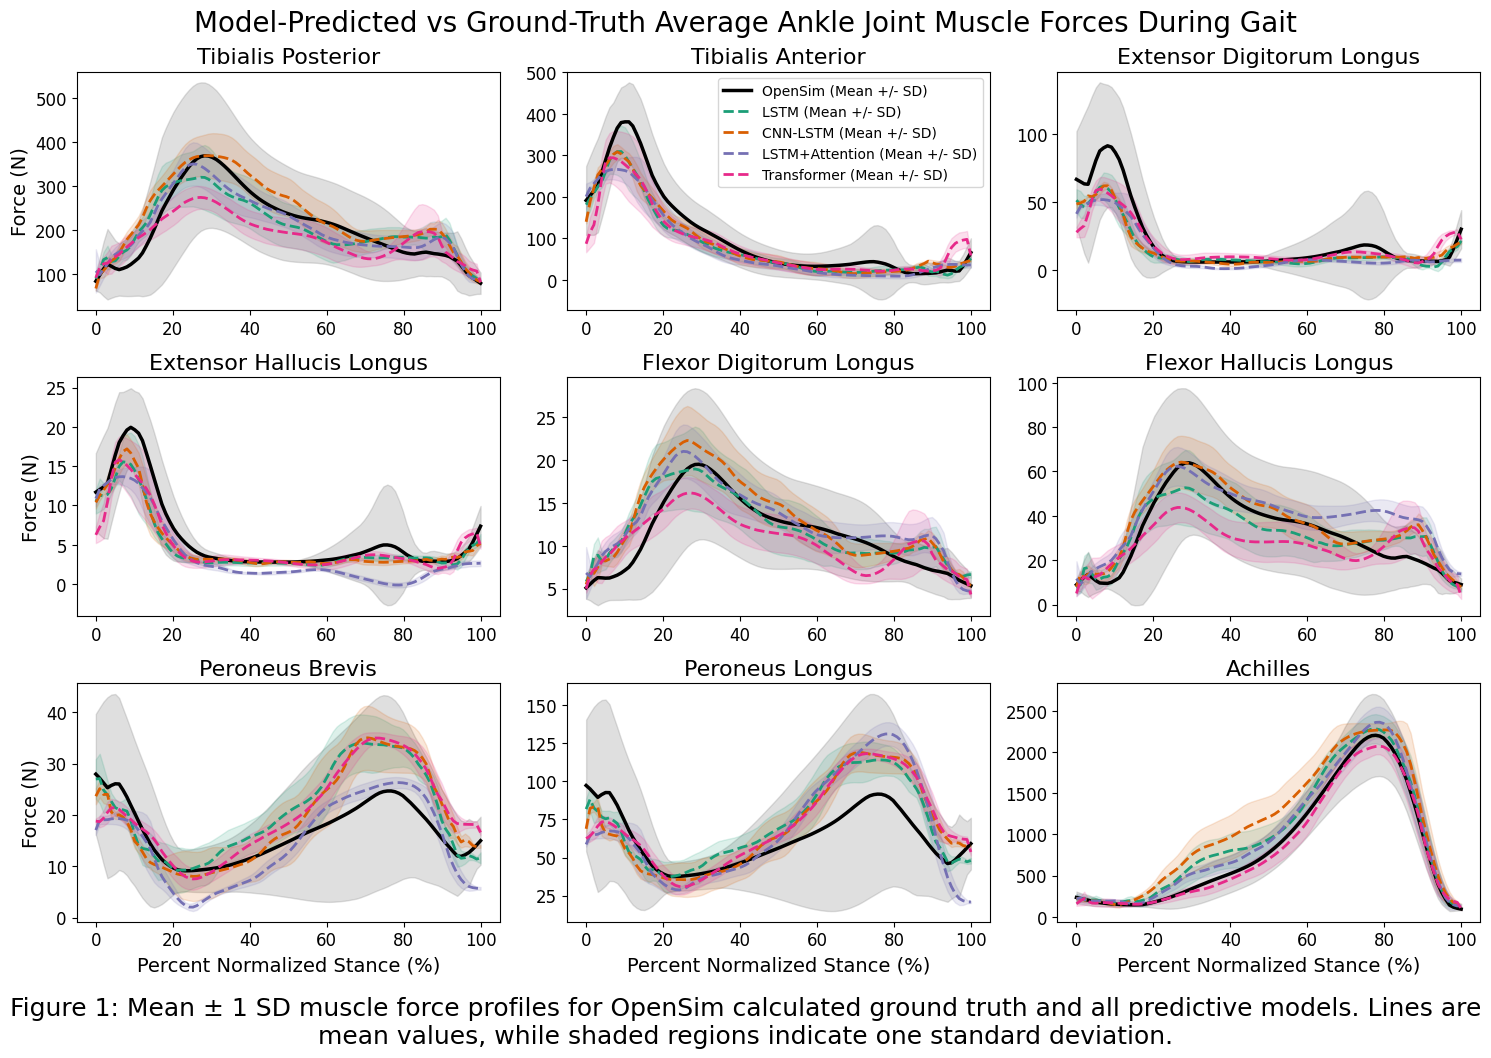

In [72]:
# Ground truth stats
true_mean = np.mean(y_test, axis=0)      
true_std  = np.std(y_test, axis=0)      

# Model stats
lstm_mean  = np.mean(lstm_pred, axis=0)
lstm_std   = np.std(lstm_pred, axis=0)

cnn_mean   = np.mean(cnnlstm_pred, axis=0)
cnn_std    = np.std(cnnlstm_pred, axis=0)

attn_mean  = np.mean(lstmattn_pred, axis=0)
attn_std   = np.std(lstmattn_pred, axis=0)

trans_mean = np.mean(transformer_pred, axis=0)
trans_std  = np.std(transformer_pred, axis=0)

pred_means = [lstm_mean, cnn_mean, attn_mean, trans_mean]
pred_stds  = [lstm_std, cnn_std, attn_std, trans_std]
perc_stance = np.linspace(0, 100, 100)
model_labels = ['LSTM (Mean +/- SD)', 'CNN-LSTM (Mean +/- SD)', 'LSTM+Attention (Mean +/- SD)', 'Transformer (Mean +/- SD)']
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']  

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true_mean[:, i], label='OpenSim (Mean +/- SD)', color='black', linewidth=2.5)
    ax.fill_between(
        perc_stance,
        true_mean[:, i] - true_std[:, i],
        true_mean[:, i] + true_std[:, i],
        color='gray', alpha=0.25
    )
    for j, (pred_m, pred_s) in enumerate(zip(pred_means, pred_stds)):
        
        ax.plot(perc_stance, pred_m[:, i],
                label=model_labels[j], color=colors[j], linewidth=2, linestyle = '--')

        ax.fill_between(
            perc_stance,
            pred_m[:, i] - pred_s[:, i],
            pred_m[:, i] + pred_s[:, i],
            color=colors[j], alpha=0.15
        )

    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance (%)', fontsize=14)
    if i % 3 == 0:
        ax.set_ylabel('Force (N)', fontsize=14)

    ax.set_title(muscle_titles[i], fontsize=16)
    if i == 1:
        ax.legend(loc='upper right', fontsize=10, frameon=True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
handles, labels = axes[0].get_legend_handles_labels()

caption_text = (
    "Figure 1: Mean ± 1 SD muscle force profiles for OpenSim calculated ground truth and all predictive models. "
    "Lines are mean values, while shaded regions indicate one standard deviation."
)

plt.figtext(
    0.5, -0.05,                 
    caption_text,
    wrap=True,
    ha='center',
    fontsize=18
)

plt.suptitle('Model-Predicted vs Ground-Truth Average Ankle Joint Muscle Forces During Gait', fontsize = 20)
plt.tight_layout()
plt.show()


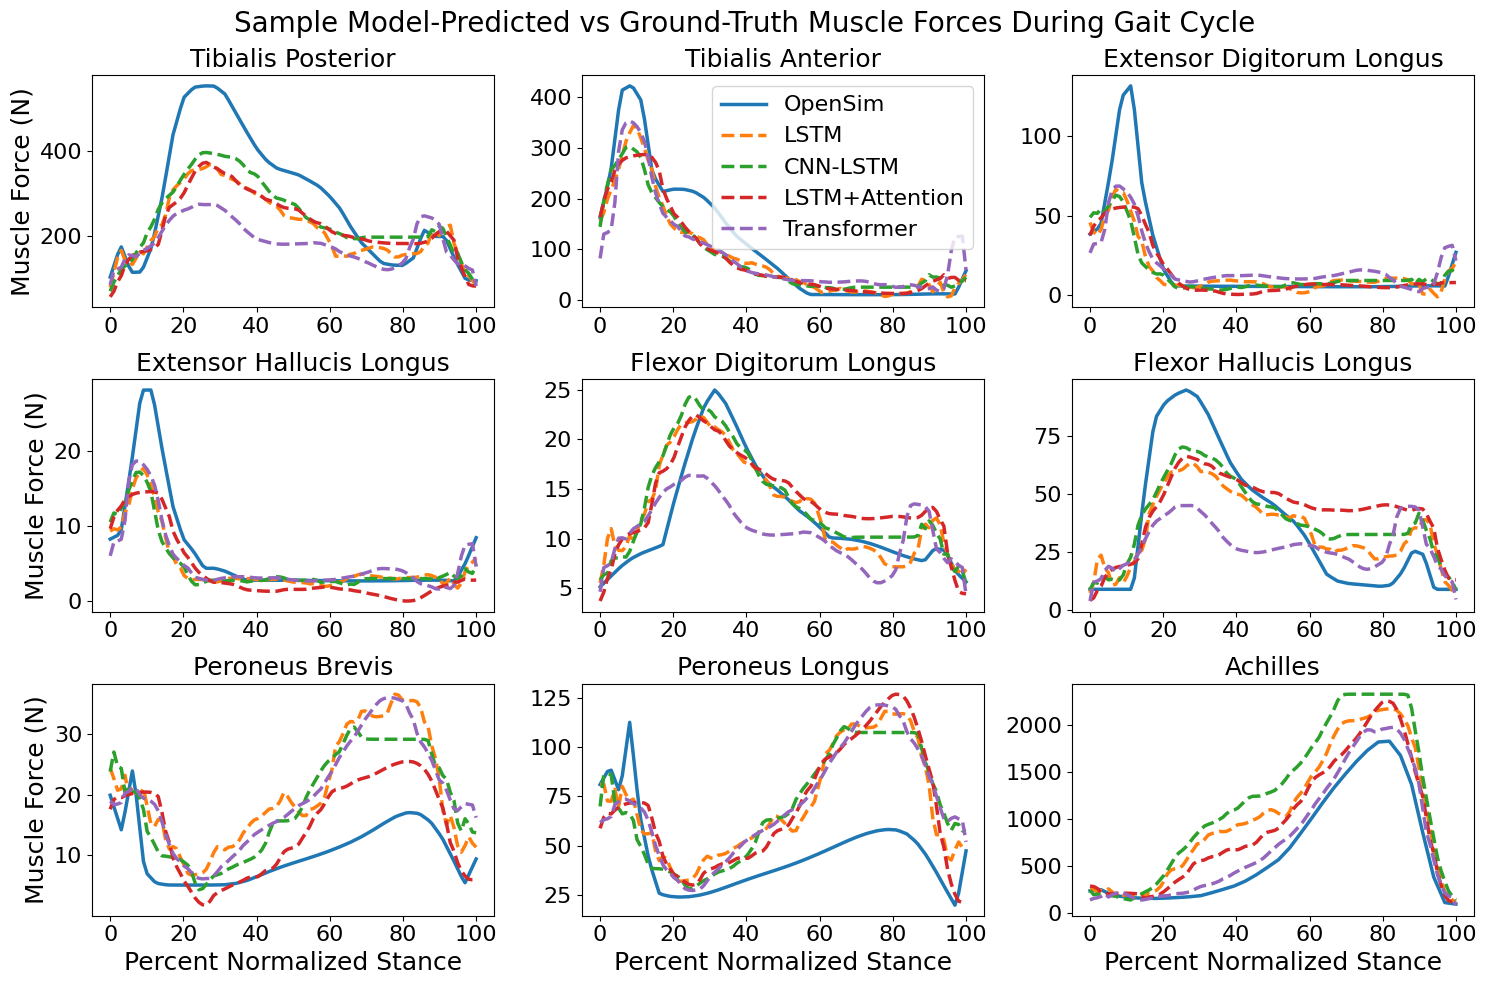

In [41]:
sample_idx = 69

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    handles, labels = axes[0].get_legend_handles_labels()

# fig.legend(
#     handles, labels,
#     loc='center left',      
#     ncol=1,                    
#     fontsize=16,
#     frameon=False,
#     bbox_to_anchor=(1, 0.5)  
# )

plt.suptitle('Sample Model-Predicted vs Ground-Truth Muscle Forces During Gait Cycle', fontsize = 20)
plt.tight_layout()
plt.show()


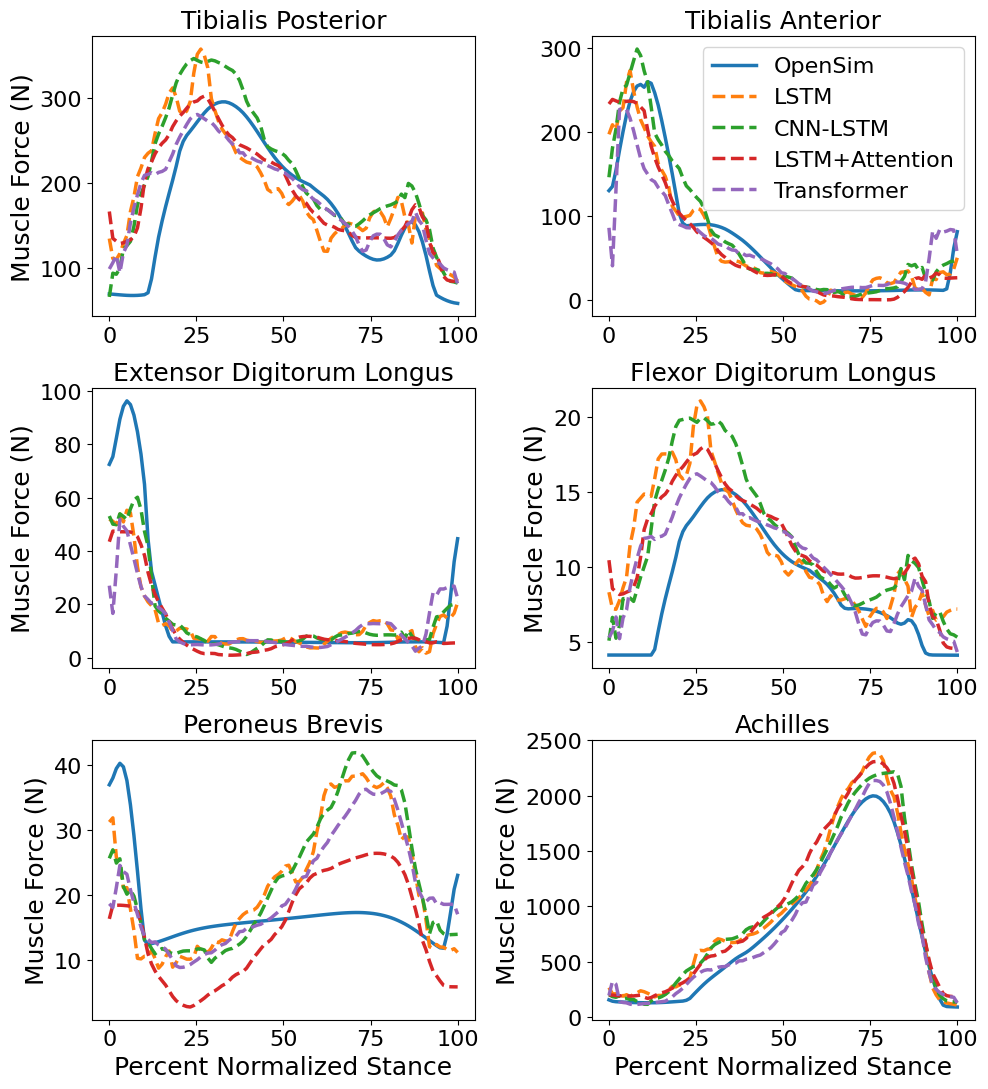

In [42]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

plot_idx = [0, 1, 2, 4, 6, 8]

fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in zip(plot_idx, axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 2 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [43]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.1415 & 0.1436 & 0.1447 & 0.1626 \\
{Tibialis Anterior} & 0.1117 & 0.1135 & 0.1182 & 0.1234 \\
{Extensor Digitorum Longus} & 0.1079 & 0.1087 & 0.1133 & 0.1133 \\
{Extensor Hallucis Longus} & 0.0782 & 0.0782 & 0.0885 & 0.0808 \\
{Flexor Digitorum Longus} & 0.1383 & 0.1479 & 0.1498 & 0.1633 \\
{Flexor Hallucis Longus} & 0.1547 & 0.1549 & 0.1704 & 0.1770 \\
{Peroneus Brevis} & 0.1231 & 0.1177 & 0.1230 & 0.1230 \\
{Peroneus Longus} & 0.1029 & 0.1030 & 0.1135 & 0.1048 \\
{Achilles} & 0.0705 & 0.1041 & 0.0624 & 0.0594 \\
\midrule
Overall & 0.0892 & 0.1109 & 0.0865 & 0.0866 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [44]:
mae_muscle_dict = {'LSTM': lstm_mae, 'CNN-LSTM': cnnlstm_mae, 'LSTM+Attention': lstmattn_mae, 'Transformer': transformer_mae}
mae_overall_dict = {'LSTM': lstm_mae_weighted, 'CNN-LSTM': cnnlstm_mae_weighted, 'LSTM+Attention': lstmattn_mae_weighted, 'Transformer': transformer_mae_weighted}

mae_table = generate_latex_table(mae_muscle_dict, mae_overall_dict, muscle_titles)
print(mae_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 78.5747 & 82.0820 & 79.8383 & 83.7806 \\
{Tibialis Anterior} & 41.8176 & 43.7002 & 44.1294 & 48.2379 \\
{Extensor Digitorum Longus} & 11.9822 & 11.9765 & 12.6982 & 14.4200 \\
{Extensor Hallucis Longus} & 1.8614 & 1.7751 & 2.7445 & 2.0693 \\
{Flexor Digitorum Longus} & 3.7527 & 3.9973 & 4.2527 & 4.2383 \\
{Flexor Hallucis Longus} & 16.7194 & 17.4391 & 19.8081 & 18.1353 \\
{Peroneus Brevis} & 9.6922 & 8.7703 & 8.9693 & 9.8868 \\
{Peroneus Longus} & 29.6772 & 28.8540 & 34.3491 & 30.9441 \\
{Achilles} & 206.8540 & 318.1668 & 189.0870 & 155.1491 \\
\midrule
Overall & 0.0630 & 0.0811 & 0.0622 & 0.0576 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [45]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.4437 & 0.4273 & 0.4186 & 0.2653 \\
{Tibialis Anterior} & 0.6940 & 0.6841 & 0.6573 & 0.6261 \\
{Extensor Digitorum Longus} & 0.3767 & 0.3667 & 0.3121 & 0.3119 \\
{Extensor Hallucis Longus} & 0.5469 & 0.5474 & 0.4201 & 0.5166 \\
{Flexor Digitorum Longus} & 0.5017 & 0.4306 & 0.4156 & 0.3060 \\
{Flexor Hallucis Longus} & 0.3978 & 0.3970 & 0.2702 & 0.2123 \\
{Peroneus Brevis} & 0.0367 & 0.1207 & 0.0395 & 0.0390 \\
{Peroneus Longus} & 0.0722 & 0.0698 & -0.1289 & 0.0363 \\
{Achilles} & 0.8552 & 0.6845 & 0.8867 & 0.8974 \\
\midrule
Overall & 0.9154 & 0.8334 & 0.9291 & 0.9316 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [46]:
norm_mae_muscle_dict = {'LSTM': lstm_norm_mae, 'CNN-LSTM': cnnlstm_norm_mae, 'LSTM+Attention': lstmattn_norm_mae, 'Transformer': transformer_norm_mae}
norm_mae_overall_dict = {'LSTM': lstm_overall_norm_mae, 'CNN-LSTM': cnnlstm_overall_norm_mae, 'LSTM+Attention': lstmattn_overall_norm_mae, 'Transformer': transformer_overall_norm_mae}

In [47]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE

    mae_muscle_dict[model] = list(mae_muscle_dict[model])
    mae_muscle_dict[model].append(mae_overall_dict[model])

    norm_mae_muscle_dict[model] = list(norm_mae_muscle_dict[model])  
    norm_mae_muscle_dict[model].append(norm_mae_overall_dict[model])  


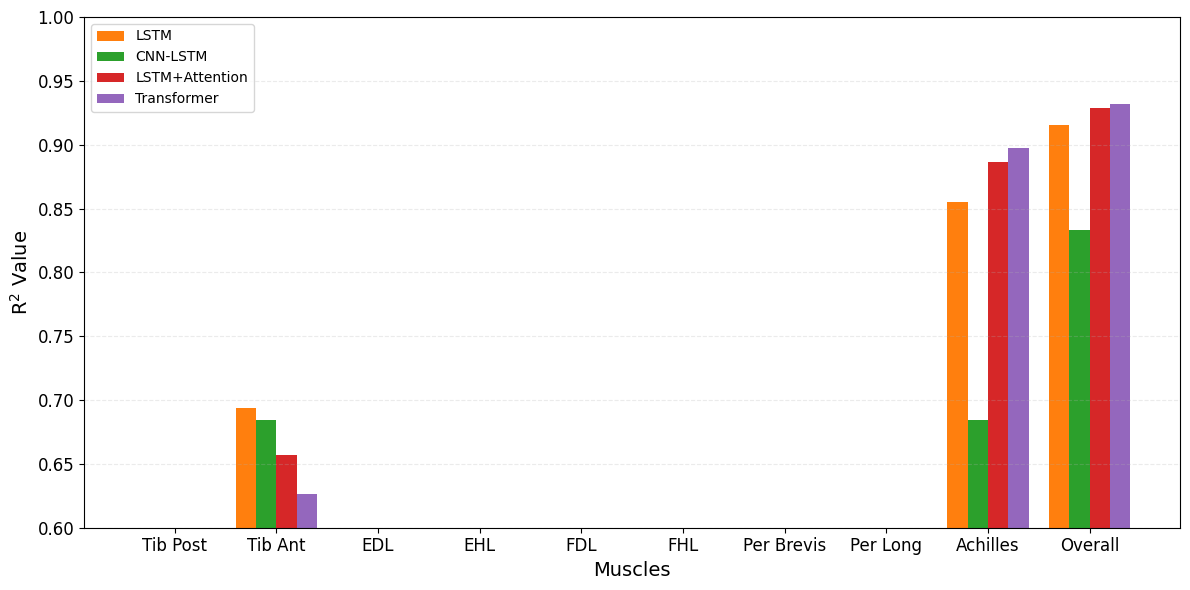

In [48]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

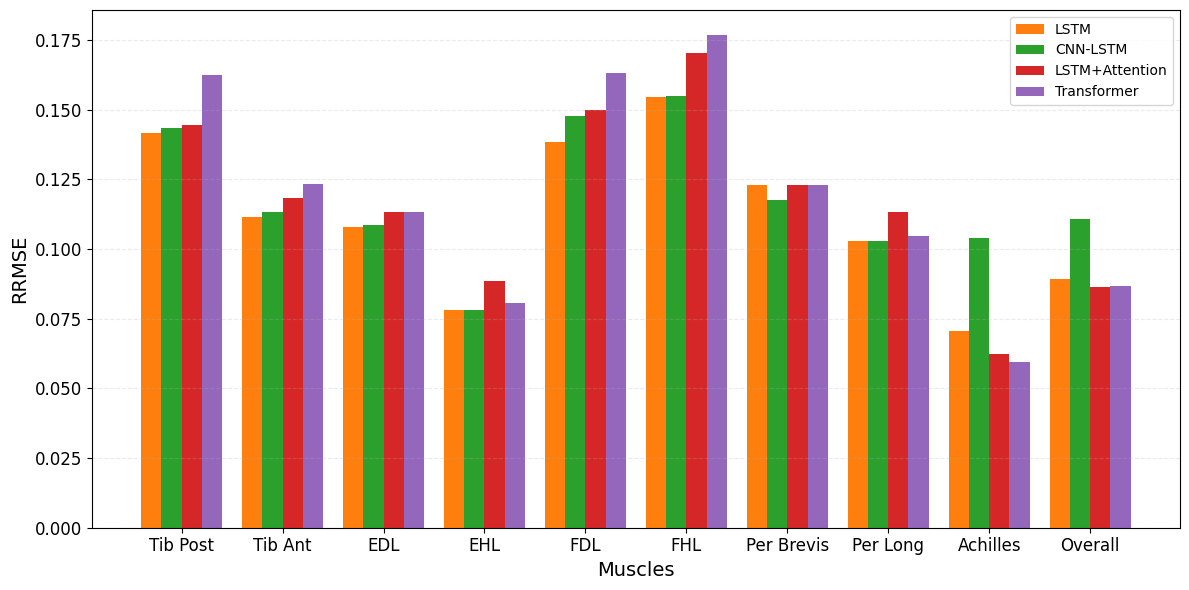

In [49]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

In [50]:
print(mae_muscle_dict)

{'LSTM': [78.57470420218512, 41.8176117004374, 11.982205043265926, 1.8614311195560214, 3.7527388612458443, 16.719449867996413, 9.692184830730094, 29.67715547292941, 206.85404770627798, 0.06295305334630562], 'CNN-LSTM': [82.08196497278796, 43.70023880935878, 11.976509002860334, 1.7750764728067658, 3.99734433042559, 17.439077961957675, 8.77032452307407, 28.854002225849925, 318.1668321218407, 0.08114030397263583], 'LSTM+Attention': [79.83833591244134, 44.12940231441106, 12.69815040458264, 2.7445095048485904, 4.252681966538494, 19.808124710164083, 8.969295902694899, 34.349067579612594, 189.087033955987, 0.06215934410143013], 'Transformer': [83.78062114510129, 48.237887398796566, 14.419950088608076, 2.0693384162699378, 4.238258676573159, 18.135342148115402, 9.886800381646994, 30.944147760237392, 155.14912660381046, 0.057603476397468587]}


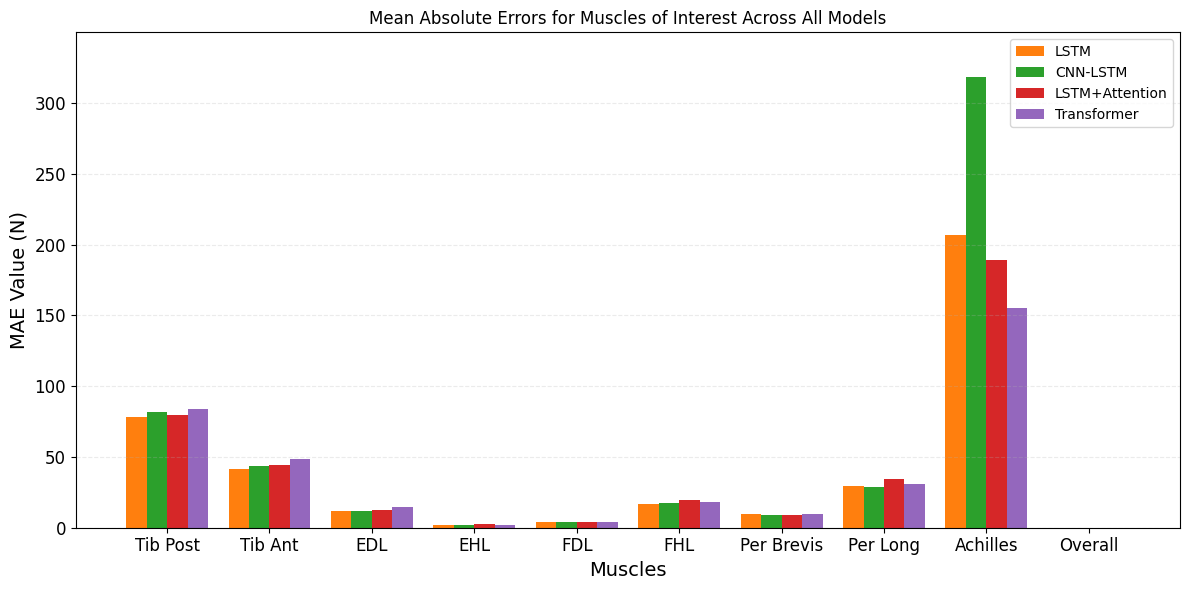

In [51]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], mae_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('MAE Value (N)', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(max(v) for v in mae_muscle_dict.values()) * 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.title('Mean Absolute Errors for Muscles of Interest Across All Models')
plt.tight_layout()
plt.show()

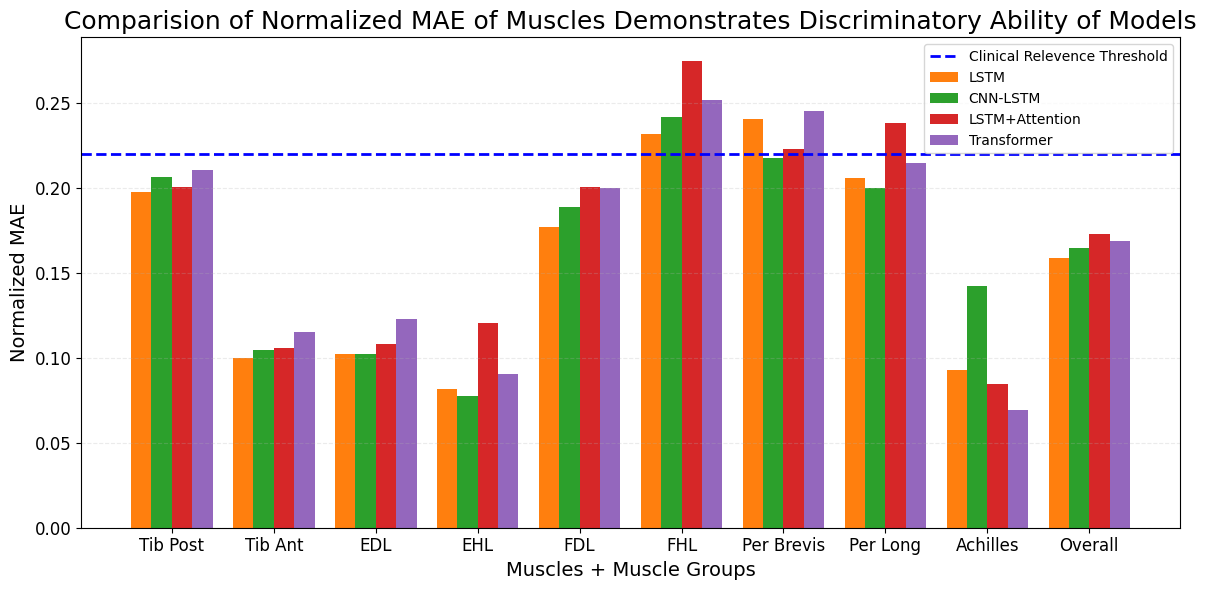

In [71]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], norm_mae_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.axhline(0.22, color='blue', linestyle='--', linewidth=2, label= 'Clinical Relevence Threshold')
plt.xlabel('Muscles + Muscle Groups', fontsize=14)
plt.ylabel('Normalized MAE', fontsize=14)
plt.title('Comparision of Normalized MAE of Muscles Demonstrates Discriminatory Ability of Models', fontsize = 18)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()